In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
evaluation_file = "/hpc/compgen/users/mpages/babe/eval1.csv"
eval_df = pd.read_csv(evaluation_file)
eval_df = eval_df[eval_df["comment"] == "pass"]
signature_columns = eval_df.columns[eval_df.columns.str.contains('>')]


# Basic rates

In [5]:
plot_df = {'Names': list(), 'Rates': list()}

for i, row in tqdm(eval_df.iterrows()):
    temp = {'Match':0, 'Mismatch':0, 'Deletion':0, 'Insertion':0}
    for s_col in signature_columns:
        k1, k2 = s_col[1], s_col[3]
        if k1 == '-':
            temp['Insertion'] += row[s_col]
        elif k2 == '-':
            temp['Deletion'] += row[s_col]
        elif k1 == k2:
            temp['Match'] += row[s_col]
        elif k1 != k2:
            temp['Mismatch'] += row[s_col]


    for n in temp.keys():
        plot_df['Names'].append(n)
        if n == 'Insertion':
            plot_df['Rates'].append(temp[n]/row['len_reference'])
            if temp[n]/row['len_reference'] > 1:
                print(row)
                
        else:
            plot_df['Rates'].append(temp[n]/row['len_basecalls'])


16570it [00:41, 394.54it/s]


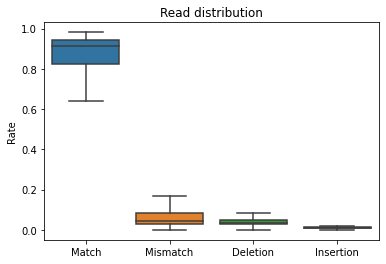

In [7]:
ax = sns.boxplot(x = 'Names', y = 'Rates', data = plot_df, showfliers = False)
ax.set_ylabel('Rate')
ax.set_title('Read distribution')
plt.show()

# Confusion matrix

In [8]:
confusion_matrix = np.zeros((5, 5))
elements = ['A', 'C', 'G', 'T', '-']

for s_col in signature_columns:
    confusion_matrix[elements.index(s_col[1]), elements.index(s_col[3])] += np.sum(eval_df[s_col])

confusion_matrix_rates = np.zeros((5, 5))
# to calculate rates we normalize in two ways
# first we calculate the match, mismatch and deletion rates based on the total
# amount of a base on the true sequence
# then we calculate the insertion rate based on the total amount of a base on 
# the predicted sequence
for i in range(4):
    confusion_matrix_rates[i] = confusion_matrix[i]/np.sum(confusion_matrix[i])
for i in range(4):
    confusion_matrix_rates[4, i] = confusion_matrix[4, i]/np.sum(confusion_matrix[:, i])


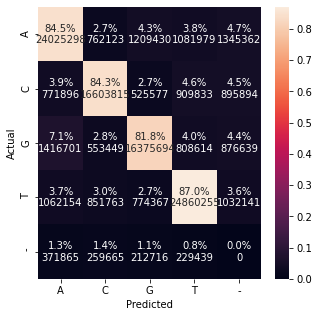

In [9]:
cm = confusion_matrix
cm_perc = confusion_matrix_rates
annot = np.empty_like(cm).astype(str)
labels = ['A', 'C', 'G', 'T', '-']
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j] * 100
        if i == j:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#plt.savefig(filename)
plt.show()

# Signature evaluation

Match, mismatch and deletions

In [10]:
bases = ["A", "C", "G", "T"]
types = ["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Missmatch", "Insertion", "Deletion"]

signatures = list()
for b in bases:
    for b1 in bases:
        for b2 in bases:
            for t in types:
                signatures.append({'Base': b, 'Context': b1+b2, 'Error': t, "Count": 0, "Rate": 0.0, "k": b+b1+b2+t})
signatures_df = pd.DataFrame(signatures)

for s_col in signature_columns:
    k1 = s_col[1] if s_col[1] != '-' else s_col[3]
    k2 = s_col[0] + s_col[-1]
    if s_col[1] == '-':
        k3 = "Insertion"
    elif s_col[3] == '-':
        k3 = "Deletion"
    elif s_col[1] == s_col[3]:
        k3 = "Match"
    else:
        k3 = "Missmatch"
    p = np.where(signatures_df["k"] == k1+k2+k3)[0]
    signatures_df.iloc[p, 3] += np.sum(eval_df[s_col])
    if k3 == 'Missmatch':
        k3 = "Missmatch_" + s_col[3]
        p = np.where(signatures_df["k"] == k1+k2+k3)[0]
        signatures_df.iloc[p, 3] += np.sum(eval_df[s_col])

for b in np.unique(signatures_df["Base"]):
    sub_df = signatures_df[signatures_df["Base"] == b]
    for c in np.unique(signatures_df["Context"]):
         subsub_df = sub_df[sub_df["Context"] == c]
         subsub_df = subsub_df[subsub_df["Error"].isin(["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion"])]
         t = np.sum(subsub_df["Count"])
         signatures_df.iloc[subsub_df.index, 4] = signatures_df.iloc[subsub_df.index, 3]/t

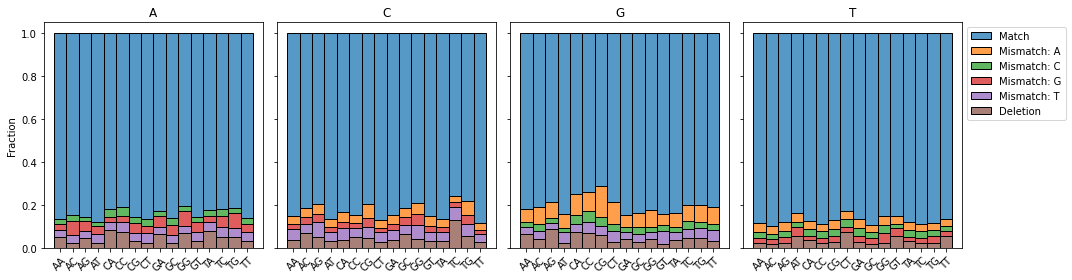

In [11]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
for i, b in enumerate(bases):
    plot_df = signatures_df[signatures_df["Base"] == b]
    plot_df = plot_df[plot_df["Error"].isin(["Match", "Missmatch_A", "Missmatch_C", "Missmatch_G", "Missmatch_T", "Deletion"])]
    sns.histplot(x = "Context", hue = "Error", weights='Rate', data = plot_df, 
                 multiple='stack', ax = axs[i])
    axs[i].set_ylabel('Fraction')
    axs[i].set_xlabel(None)
    axs[i].set_title(b)
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
    if i < 3:
        axs[i].get_legend().remove()
    else:
        legend = axs[i].get_legend()
        legend.set_bbox_to_anchor((1, 1))
        legend.set_title(None)
        legend.texts[1].set_text("Mismatch: A")
        legend.texts[2].set_text("Mismatch: C")
        legend.texts[3].set_text("Mismatch: G")
        legend.texts[4].set_text("Mismatch: T")
fig.tight_layout()


# Signature evaluation 
Insertions

In [12]:
bases = ["A", "C", "G", "T"]

signatures = list()
for b in bases:
    for b1 in bases:
        for b2 in bases:
            signatures.append({'Context': b1+b2, 'Error': b, "Count": 0, "Rate": 0.0, "k": b1+b+b2})
signatures_df = pd.DataFrame(signatures)

for s_col in signature_columns:
    if s_col[1] != '-':
        continue

    k1 = s_col[0]
    k3 = s_col[-1]
    k2 = s_col[3]

    p = np.where(signatures_df["k"] == k1+k2+k3)[0]
    signatures_df.iloc[p, 2] += np.sum(eval_df[s_col])

for c in np.unique(signatures_df["Context"]):
    subsub_df = signatures_df[signatures_df["Context"] == c]
    t = np.sum(subsub_df["Count"])
    signatures_df.iloc[subsub_df.index, 3] = signatures_df.iloc[subsub_df.index, 2]/t
    

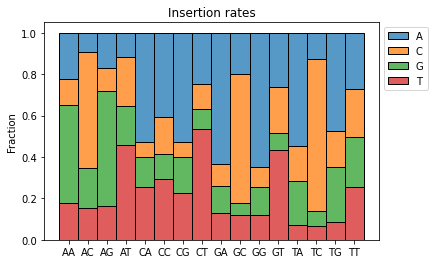

In [13]:
plot_df = signatures_df
plt.figure()
ax = sns.histplot(x = "Context", hue = "Error", weights='Rate', data = plot_df, multiple='stack')
ax.set_ylabel('Fraction')
ax.set_xlabel(None)
ax.set_title('Insertion rates')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
legend.set_title(None)